In [43]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import time
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report
import warnings
from statistics import mean
import csv
from joblib import dump
from joblib import load
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns 

In [44]:
def Calcul_perfermance(total_ex, models):
    f1_scores = []  # Liste pour stocker les scores F1 de chaque modèle
    
    for model in models:
        if model==DNN_attacker:
            total_ex_ = scaler.transform(total_ex) # For DNN
            y_adv = model.predict(total_ex_)
            pred_class = np.argmax(y_adv, 1) # For DNN
        elif model == XGBoost_attacker:
            # Préparer les données pour XGBoost 
            AdverData = pd.DataFrame(columns=UnTarget_Data_reduced.columns)
            for tuple_ in total_ex:
                row_df = pd.DataFrame([tuple_], columns=UnTarget_Data_reduced.columns)
                AdverData = pd.concat([AdverData, row_df], ignore_index=True)
            pred_class = model.predict(xgb.DMatrix(AdverData))
        else:    
            pred_class = model.predict(total_ex)
        report = classification_report(pred_class, y_UnTarget_Data_reduced, output_dict=True)
        f1_scores.append(report['weighted avg']['f1-score'])

    palette = sns.color_palette("husl", len(models))

    
    model_names = [model.__class__.__name__+"_Attacker" for model in models]
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, f1_scores, color=palette, width=0.4)  
    plt.xlabel('Modèles')
    plt.ylabel('F1-Score')
    plt.title('Performance des modèles après la défense antagoniste')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)  
    plt.tight_layout()
    plt.show()


In [66]:
def calcule_mean(Dataset_):  # Calcule la moyenne de chaque caractéristique
    meanFeature = np.array([])
    for col in Feature_independent_modifiable:
        mean = Dataset_[col].mean()
        meanFeature = np.append(meanFeature, mean)
    return meanFeature

def calcule_max(Dataset_):  # Calcule le maximum de chaque caractéristique
    maxFeature = np.array([])
    for col in Feature_independent_modifiable:
        maxFeature = np.append(maxFeature, Dataset_[col].max())
    return maxFeature

def calcul_direction(features_vector_, Target_Mean_):  # Pour calculer la direction de perturbation
    Direction = []
    for i in range(len(Target_Mean_)):
        if features_vector_[i] <= Target_Mean_[i]:
            Direction.append(1)
        else:
            Direction.append(-1)
    return Direction

def calcule_Difference(features_vector_, Target_Mean_):  # Pour calculer la distance entre l'instance originale et la moyenne de la classe ciblée
    difference = []
    for i in range(len(Target_Mean_)):
        difference.append(abs(features_vector_[i] - Target_Mean_[i]))
    return difference

def calcule_Pert(Masq_,difference_Mean_, Direction_Perturbation, iteration_, Taux_):  # Pour calculer la perturbation à ajouter à l'instance originale
    Perturbation = []
    for i in range(len(Direction_Perturbation)):
        Per = np.array(Masq_[i]) * (difference_Mean_[i] * (iteration_ * Taux_) * Direction_Perturbation[i])
        Perturbation.append(Per)
    return Perturbation


In [95]:
# Chargement du Dataset
DataSet_ = "IPFIXRecords"  # Dataset utilisé
 
# Charger les données d'entraînement du défenseur
X_train_defender = pd.read_csv('Dataset/'+DataSet_+'/X_train_defender.csv')
y_train_defender = pd.read_csv('Dataset/'+DataSet_+'/y_train_defender.csv')

# Charger les données de test du défenseur
X_test_defender = pd.read_csv('Dataset/'+DataSet_+'/X_test_defender.csv')
y_test_defender = pd.read_csv('Dataset/'+DataSet_+'/y_test_defender.csv')


# Suppression des caractéristiques dépendantes et non modifiables
Feature_independent_modifiable = X_train_defender.columns
indices_a_supprimer = [1, 2, 3]  # Suppression des caractéristiques dépendantes et non modifiables
Feature_independent_modifiable = Feature_independent_modifiable.drop(X_train_defender.columns[indices_a_supprimer])
Dataset = X_test_defender
Dataset['Ndevice'] = y_test_defender

# Définition des classes cibles pour les différents Dataset
dataset_keys = {
    "IPFIXRecords": [7, 8, 16],
    "TrafficTraces": [1, 4, 6],
    "IPFIXHome": [1, 4, 12]
}
Target = dataset_keys[DataSet_]

# Séparation des données cibles et non cibles
Target_Data1 = Dataset[Dataset['Ndevice'] == Target[0]]
Target_Data2 = Dataset[Dataset['Ndevice'] == Target[1]]
Target_Data3 = Dataset[Dataset['Ndevice'] == Target[2]]

Target_Data = pd.concat([Target_Data1, Target_Data2, Target_Data3])
UnTarget_Data = Dataset[(Dataset['Ndevice'] != Target[0]) &
                        (Dataset['Ndevice'] != Target[1]) &
                        (Dataset['Ndevice'] != Target[2])]

# Calcul des moyennes des caractéristiques pour chaque classe cible
Mean_Feature_Target1 = calcule_mean(Target_Data1)
Mean_Feature_Target2 = calcule_mean(Target_Data2)
Mean_Feature_Target3 = calcule_mean(Target_Data3)
# Calcul des valeurs maximales des caractéristiques
Max_feature = calcule_max(UnTarget_Data)

# Réduction des données non cibles
UnTarget_Data_reduced, not_used = train_test_split(
    UnTarget_Data, random_state=42, stratify=UnTarget_Data.Ndevice, shuffle=True, train_size=0.108)
y_UnTarget_Data_reduced = UnTarget_Data_reduced['Ndevice']
UnTarget_Data_reduced = UnTarget_Data_reduced.drop(columns=['Ndevice'])
print(UnTarget_Data_reduced.shape)


(3000, 14)


In [99]:
# Modèle de substitution utilisé
Substitute_model = load('Model\\' + DataSet_ + '\\DefenderModel\\XGBoost_defender.joblib')

# Chargement et ajustement du scaler
scaler = StandardScaler()
scaler.fit(X_train_defender)

# Modèles utilisés par l'attaquant
knn_attacker = load('Model\\' + DataSet_ + '\\AttackerModel\\knn_attacker.joblib')
RandomForest_attacker = load('Model\\' + DataSet_ + '\\AttackerModel\\RandomForest_attacker.joblib')
XGBoost_attacker = load('Model\\' + DataSet_ + '\\AttackerModel\\XGBoost_attacker.joblib')
DecisionTree_attacker = load('Model\\' + DataSet_ + '\\AttackerModel\\DecisionTree_attacker.joblib')
DNN_attacker = tf.keras.models.load_model('Model\\' + DataSet_ + '\\AttackerModel\\DNN_attacker.h5')
models_attaque = [knn_attacker,RandomForest_attacker, DNN_attacker, XGBoost_attacker, DecisionTree_attacker]

# Masques utilisés pour chaque dataset
Masqs_ = {
    "IPFIXRecords":[
    (1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0), (0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1), 
    (0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1), (0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0),
    (1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0), (0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1),
    (0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1), (0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1),
    (0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1), (0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1),
    (1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1), (1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1),
    (1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0), (1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1),
    (1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1), (1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1),
    (1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1),
    (1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
],

    "TrafficTraces":[
    (1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0), (0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1), 
    (0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1), (0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0),
    (1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0), (0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1),
    (0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1), (0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1),
    (0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1), (1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1),
    (1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1), (1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1),
    (1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0), (1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1),
    (1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1), (1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1),
    (1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1), (1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1),
    (1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
],
    "IPFIXHome": [
    (0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1),(0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1),
    (0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1),(0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1),
    (0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0),(0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1),
    (0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1),(0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0),
    (0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0),(1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0),
    (1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0),(1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0),
    (1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0),(1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1),
    (1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1),(0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0),
    (0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0),(1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0),
    (1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0),(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
]
}
Masks=Masqs_[DataSet_]


In [102]:
from tqdm import tqdm

Taux = 0.03
warnings.filterwarnings("ignore", category=UserWarning)

adversarial_example = []
total_example = []
steps = []
masks = []
start = time.process_time()
for index, row in tqdm(UnTarget_Data_reduced.iterrows(), total=len(UnTarget_Data_reduced)):
    breaked = False
    features_vector = [row[col] for col in Feature_independent_modifiable]

    distances = [
        np.linalg.norm(np.array(features_vector) - np.array(mean_feature))
        for mean_feature in [Mean_Feature_Target1, Mean_Feature_Target2, Mean_Feature_Target3]
    ]
    min_distance_index = np.argmin(distances)
    Target_Mean = [Mean_Feature_Target1, Mean_Feature_Target2, Mean_Feature_Target3][min_distance_index]

    Direction_Perturbation = []
    Direction_Perturbation = calcul_direction(features_vector, Target_Mean)
    difference_Mean = []
    difference_Mean = calcule_Difference(features_vector, Target_Mean)

    clean__ = []
    clean__.append(np.array(row))
    clean__ = xgb.DMatrix(pd.DataFrame(clean__, columns=UnTarget_Data_reduced.columns)) #pour XGBoost
    #clean__ = scaler.transform(clean_) # pour DNN
    test_row2 = Substitute_model.predict(clean__)
    #test_row2 = np.argmax(test_row2, 1) #pour DNN
    for i in range(1, 11):
        if (breaked == False):
            for Masq in Masks:
                adv = np.array(row)
                perturbation = calcule_Pert(Masq, difference_Mean, Direction_Perturbation, i, Taux)
                # Ajout de la perturbation 
                adv[0] = adv[0] + perturbation[0]  # Duration
                adv[4] = adv[4] + perturbation[1]  # Nombre total de paquets de source à destination
                adv[4] = int(adv[4])
                adv[5] = adv[5] + perturbation[2]  # Nombre totale d’octets de source à destination
                adv[5] = int(adv[5])
                adv[6] = adv[6] + perturbation[3]  # Moyenne des temps inter-arrivées pour les paquets émis par la source
                adv[7] = adv[7] + perturbation[4]  # Taille maximale des paquets émis par la source
                adv[7] = int(adv[7])
                adv[8] = adv[8] + perturbation[5]  # Taille moyenne des paquets émis par la source
                adv[9] = adv[9] + perturbation[6]  # Nombre total de paquets de destination à source
                adv[9] = int(adv[9])
                adv[10] = adv[10] + perturbation[7] # Nombre totale d’octets de destination à source
                adv[10] = int(adv[10])
                adv[11] = adv[11] + perturbation[8] # Moyenne des temps inter-arrivées pour les paquets reçus par la source
                adv[12] = adv[12] + perturbation[9] # Taille maximale des paquets reçus par la source
                adv[12] = int(adv[12])
                adv[13] = adv[13] + perturbation[10]# Taille moyenne des paquets reçus par la source

                # Contraintes syntaxiques
                # Assurer la plage valide des caractéristiques
                if adv[0] > Max_feature[0]:
                    adv[0] = Max_feature[0]
                for i in range(0, 12):
                    if adv[i] > Max_feature[i - 1]:
                        adv[i] = Max_feature[i - 1]
                for i in range(0, 14):
                    if adv[i] < 0:
                        adv[i] = 0
                # Contraintes syntaxiques
                # Assurer la plage valide des caractéristiques

                if (adv[5] > 0) & (adv[4] == 0):
                    adv[4] == 1
                if (adv[10] > 0) & (adv[9] == 0):
                    adv[9] == 1

                # Cas où la taille moyenne de paquet > taille max de paquet
                if adv[8] > adv[7]:
                    adv[7] = int(adv[8]) + 1
                if adv[13] > adv[12]:
                    adv[12] = int(adv[13]) + 1

                # Contraintes sémantiques
                # nombre total de paquets et de bytes
                adv[2] = adv[4] + adv[9]
                adv[3] = adv[5] + adv[10]

                adv2 = []
                adv2.append(adv)
                adv2 = xgb.DMatrix(pd.DataFrame(adv2, columns=UnTarget_Data_reduced.columns))#pour XGBoost
                #adv2 = scaler.transform(adv2) # pour DNN
                test = Substitute_model.predict(adv2)
                #test = np.argmax(test, 1) #pour DNN
                if (test in Target):
                    adversarial_example.append(adv)
                    steps.append(i)
                    breaked = True
                    break
    total_example.append(adv)

end = time.process_time() - start
print("Time taken to generate:", end, "seconds")


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [08:02<00:00,  6.22it/s]

Time taken to generate: 3003.984375 seconds


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


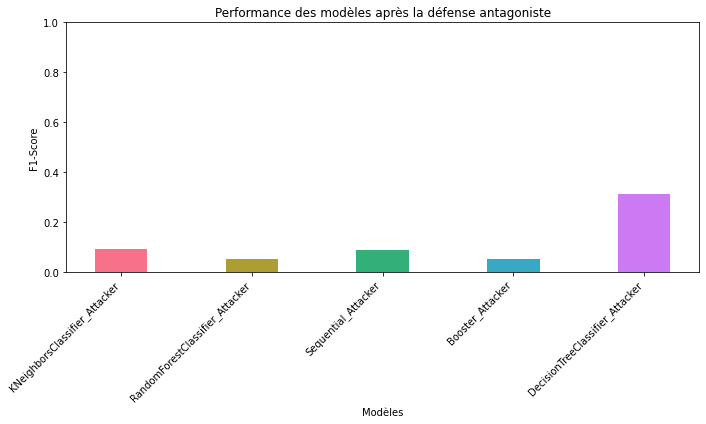

In [103]:
Calcul_perfermance(total_example,models_attaque)